# Verarbeitung, Analyse und Darstellung von Daten 

Python Bibliotheken (alle eignen sich hervorragend für die Verarbeitung sehr großer Datensätze):

Schnelle Datenanalyse und -manipulation - Pandas:
https://pandas.pydata.org/docs/

Bibliothek zur Datenvisualisierung insbesondere für statistische Grafiken - Seaborn:
https://seaborn.pydata.org/

Leistungsstarke Bibliothek für wissenschaftliches Rechnen - NumPy:
https://numpy.org/

Leistungsstarke Bibliothek mit grundlegenden Algorithmen für wissenschaftliches Rechnen:
https://scipy.org/

Datensatz der ZAMG - Zentralanstalt für Meteorologie und Geodynamik:
https://data.hub.zamg.ac.at/

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import scipy.stats as sp
import matplotlib.pyplot as plt

Daten lesen

In [15]:
pfad = "ZAMG_GRAZ_Datensatz_20000101_20221207.csv"
df=pd.read_csv(pfad, parse_dates=['time'])
df=df.set_index('time')
df.head()

,station,D6X,LT2,PPX,RSD,RSX,SCH,SST,SUX,TT3,TT5,TTX,VKM,WSD,WSK
time,,,,,,,,,,,,,,,
2000-01-01 00:00:00,16412,331.0,NaN,979.0,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.3,NaN,335.0,NaN
2000-01-01 01:00:00,16412,339.0,NaN,979.5,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.9,NaN,322.0,NaN
2000-01-01 02:00:00,16412,337.0,NaN,979.7,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-5.1,NaN,317.0,NaN
2000-01-01 03:00:00,16412,6.0,NaN,979.7,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.6,NaN,355.0,NaN
2000-01-01 04:00:00,16412,342.0,NaN,979.6,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.5,NaN,324.0,NaN


Daten bereinigen

In [16]:
df.dropna(axis=1, how='any')

,station
time,
2000-01-01 00:00:00,16412
2000-01-01 01:00:00,16412
2000-01-01 02:00:00,16412
2000-01-01 03:00:00,16412
2000-01-01 04:00:00,16412
...,...
2022-12-07 19:00:00,16412
2022-12-07 20:00:00,16412
2022-12-07 21:00:00,16412


In [17]:
df

,station,D6X,LT2,PPX,RSD,RSX,SCH,SST,SUX,TT3,TT5,TTX,VKM,WSD,WSK
time,,,,,,,,,,,,,,,
2000-01-01 00:00:00,16412,331.0,NaN,979.0,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.3,NaN,335.0,NaN
2000-01-01 01:00:00,16412,339.0,NaN,979.5,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.9,NaN,322.0,NaN
2000-01-01 02:00:00,16412,337.0,NaN,979.7,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-5.1,NaN,317.0,NaN
2000-01-01 03:00:00,16412,6.0,NaN,979.7,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.6,NaN,355.0,NaN
2000-01-01 04:00:00,16412,342.0,NaN,979.6,NaN,0.0,NaN,NaN,0.0,NaN,4.9,-4.5,NaN,324.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07 19:00:00,16412,123.0,2.8,970.4,0.0,0.0,NaN,NaN,0.0,7.1,NaN,3.2,NaN,171.0,NaN
2022-12-07 20:00:00,16412,168.0,2.9,970.3,0.0,0.0,NaN,NaN,0.0,7.1,NaN,3.1,NaN,236.0,NaN
2022-12-07 21:00:00,16412,176.0,2.6,970.3,0.0,0.0,NaN,NaN,0.0,7.1,NaN,2.6,NaN,155.0,NaN


Was bedeuten die Kürzel? - Metadaten

In [18]:
pfad_metadaten = "ZAMG_Parameter-Metadaten.csv"
df_meta=pd.read_csv(pfad_metadaten, quotechar = '*')
df_meta

,Identifier,Kurzbeschreibung,Beschreibung,Einheit
0,D2X,Windrichtung in Sektoren,Windrichtung in Sektoren: 32-teilig,NaN
1,D2X_qflag,Qualitätsqflag für D2X,"Qualitätsqflag für D2X - Qualitätsflag={0-2: ungeprüft, 3: automatisch geprüft}",NaN
2,D2X_typ,Qualitätstyp für D2X,"Qualitätstyp für D2X - Qualitätsflag={0-2: nicht geprüft, 3-5: automatisch geprüft, 6: manuell endgeprüft}",NaN
3,D6X,Windrichtung,Windrichtung in ° - vektorielles Mittel aus 10 Minuten-Werten über die Stunde ((hh-1):10 - hh:00),°
4,D6X_qflag,Qualitätsqflag für D6X,"Qualitätsqflag für D6X - Qualitätsflag={0-2: ungeprüft, 3: automatisch geprüft}",NaN
...,...,...,...,...
88,WSX_qflag,Qualitätsqflag für WSX,"Qualitätsqflag für WSX - Qualitätsflag={0-2: ungeprüft, 3: automatisch geprüft}",NaN
89,WSX_typ,Qualitätstyp für WSX,"Qualitätstyp für WSX - Qualitätsflag={0-2: nicht geprüft, 3-5: automatisch geprüft, 6: manuell endgeprüft}",NaN
90,WSZ,Zeit der Windspitze,Zeit der Windspitze - zum maximalen ffx gehöriges zeitx (hh:mm) im Format hhmm,NaN
91,WSZ_qflag,Qualitätsqflag für WSZ,"Qualitätsqflag für WSZ - Qualitätsflag={0-2: ungeprüft, 3: automatisch geprüft}",NaN


In [19]:
pd.set_option('display.max_colwidth', None)                        #Zeigt gesamte Spalte

In [20]:
df_meta[df_meta["Identifier"]=="D6X"]

,Identifier,Kurzbeschreibung,Beschreibung,Einheit
3,D6X,Windrichtung,Windrichtung in ° - vektorielles Mittel aus 10 Minuten-Werten über die Stunde ((hh-1):10 - hh:00),°


In [21]:
df.columns

Index(['station', 'D6X', 'LT2', 'PPX', 'RSD', 'RSX', 'SCH', 'SST', 'SUX',
       'TT3', 'TT5', 'TTX', 'VKM', 'WSD', 'WSK'],
      dtype='object')

In [22]:
df_meta[df_meta["Identifier"].isin(df.columns)]

,Identifier,Kurzbeschreibung,Beschreibung,Einheit
3,D6X,Windrichtung,Windrichtung in ° - vektorielles Mittel aus 10 Minuten-Werten über die Stunde ((hh-1):10 - hh:00),°
24,LT2,Lufttemperatur in 5 cm,Lufttemperatur in 5 cm über dem Boden - minimaler 10 Minuten bzw. 1 Minuten-Wert der letzten Stunde,°C
27,PPX,Luftdruck Stationsniveau,"Luftdruck Stationsniveau - letzter 10 Minutenwert der vollen Stunde (01:00, 02:00,…)",mbar
36,RSD,Niederschlagsdauer,Niederschlagsdauer - 60 Minuten-Summe ((hh-1):00:01 - hh:00:00) der 1 Minuten-Werte des Niederschlagmelders,min
39,RSX,Niederschlag,Niederschlag - 60 Minuten-Summe ((hh-1):00:01 - hh:00:00) der 1 Minuten-Werte des Niederschlags,mm
42,SCH,Schneehöhe,"Schneehöhe - aus Schneepegel, letzter 10 Minutenwert der vollen Stunde (01:00, 02:00,…)",cm
45,SST,Direkte Sonnenstrahlung (direkt),Direkte Sonnenstrahlung (direkt),J/cm² pro Stunde
48,SUX,Sonnenscheindauer,Sonnenscheindauer - Summe((hh-1):10 -hh:00) in sec/3600 gerundet,h
60,TT3,Erdbodentemperatur in 20 cm Tiefe,"Erdbodentemperatur in 20 cm Tiefe - letzter 10 Minutenwert der vollen Stunde (01:00, 02:00,…)",°C
66,TT5,Erdbodentemperatur in 100 cm Tiefe,"Erdbodentemperatur in 100 cm Tiefe - letzter 10 Minutenwert der vollen Stunde (01:00, 02:00,…)",°C


Datenanalyse mit Pandas - deskriptive Statistik

In [23]:
df.describe()

,station,D6X,LT2,PPX,RSD,RSX,SCH,SST,SUX,TT3,TT5,TTX,VKM,WSD,WSK
count,201048.0,165122.000000,111013.00000,165341.000000,111546.000000,165496.000000,0.0,0.0,165712.000000,107158.000000,56533.000000,165425.000000,0.0,165123.000000,0.0
mean,16412.0,176.539226,10.09573,972.121387,4.716718,0.096464,NaN,NaN,0.244329,11.698582,11.522806,10.886802,NaN,187.689734,NaN
std,0.0,119.579081,9.50053,7.500822,14.256677,0.774018,NaN,NaN,0.391985,6.595233,5.624986,8.797348,NaN,113.467211,NaN
min,16412.0,0.000000,-15.90000,931.900000,0.000000,0.000000,NaN,NaN,0.000000,0.100000,0.000000,-17.400000,NaN,0.000000,NaN
25%,16412.0,56.000000,2.60000,967.700000,0.000000,0.000000,NaN,NaN,0.000000,5.400000,6.000000,3.800000,NaN,76.000000,NaN
50%,16412.0,161.000000,9.60000,972.400000,0.000000,0.000000,NaN,NaN,0.000000,11.900000,11.800000,11.000000,NaN,165.000000,NaN
75%,16412.0,313.000000,16.20000,976.800000,0.000000,0.000000,NaN,NaN,0.500000,17.900000,16.800000,17.600000,NaN,311.000000,NaN
max,16412.0,360.000000,50.70000,1111.100000,60.000000,52.600000,NaN,NaN,1.000000,29.300000,20.600000,37.800000,NaN,360.000000,NaN


Wann gab es Niederschlag über 30mm pro Stunde?

In [24]:
len(df[df['RSX']==0])

152391

In [25]:
len(df[df['RSX']<0.0000001])/165496

0.9208137961038333

Visualisieren

<Axes: xlabel='time'>

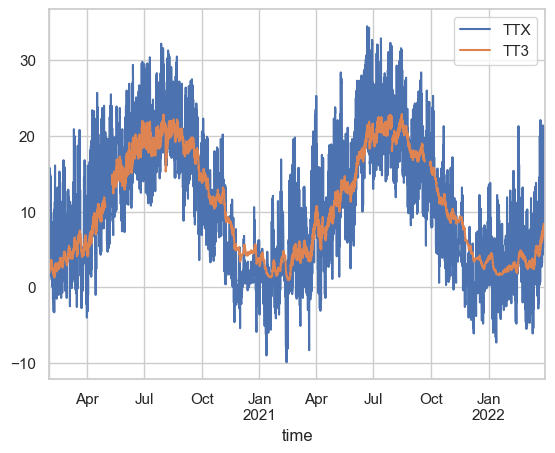

In [26]:
df[['TTX', 'TT3']]['2020-2':'2022-3'].plot()

Text(0, 0.5, 'Anzahl der Werte in der jeweiligen Klasse')

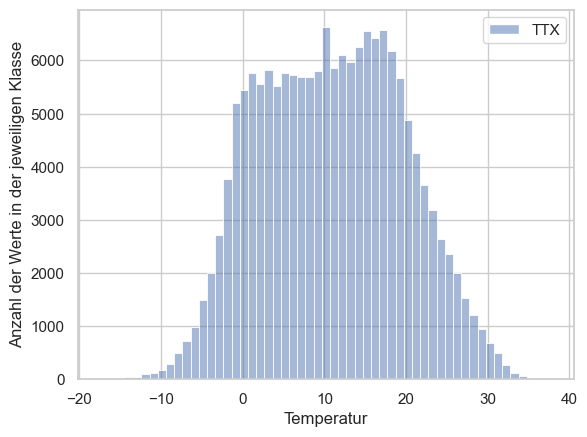

In [27]:
histogramm=sns.histplot([df['TTX']],binwidth=1, stat="count")
histogramm.set_xlabel("Temperatur")
histogramm.set_ylabel("Anzahl der Werte in der jeweiligen Klasse")

Text(0, 0.5, 'Relative Häufigkeitsdichte')

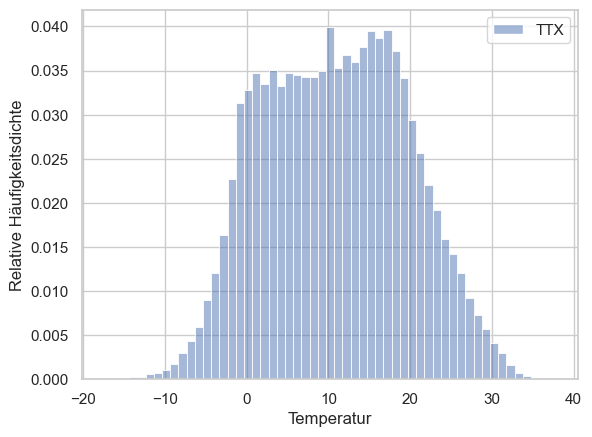

In [28]:
histogramm=sns.histplot([df['TTX']],binwidth=1, stat="density")
histogramm.set_xlabel("Temperatur")
histogramm.set_ylabel("Relative Häufigkeitsdichte")

Text(0, 0.5, 'Werte in der jeweiligen Klasse in Prozent')

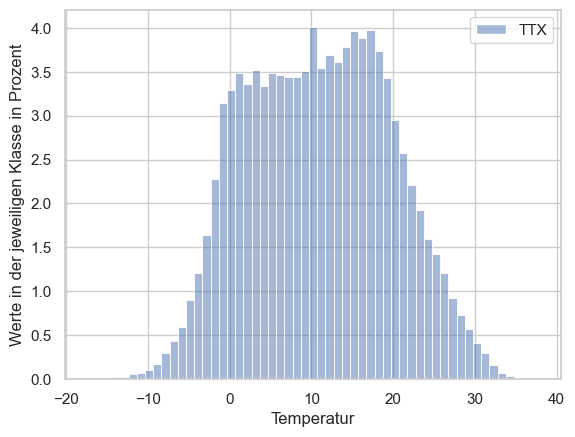

In [29]:
histogramm=sns.histplot([df['TTX']],binwidth=1, stat="percent")
histogramm.set_xlabel("Temperatur")
histogramm.set_ylabel("Werte in der jeweiligen Klasse in Prozent")

Datenlücke

<Axes: xlabel='time'>

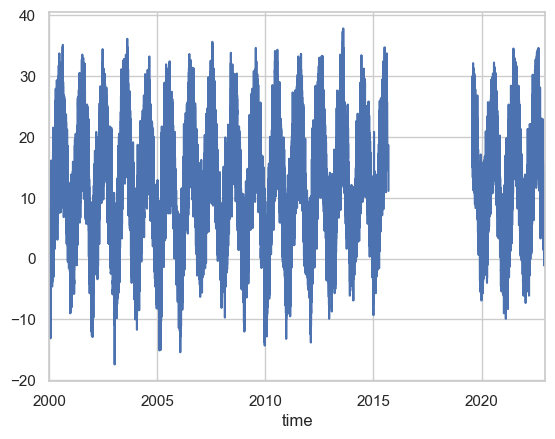

In [30]:
df['TTX'].plot()

Zeitreihen Resampling - Datengranularität

In [31]:
df_TTX = df['TTX'].resample('m').mean()

C:\Users\jana.reiter\AppData\Local\Temp\ipykernel_8020\1882553146.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TTX = df['TTX'].resample('m').mean()


<Axes: xlabel='time'>

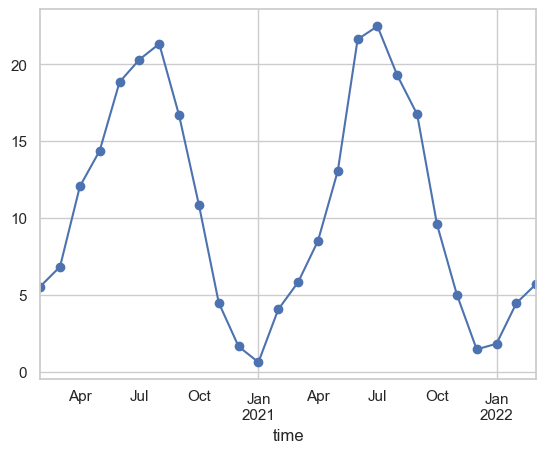

In [32]:
df_TTX['2020-2':'2022-3'].plot(marker='o')

C:\Users\jana.reiter\AppData\Local\Temp\ipykernel_8020\2899529593.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_RSX = df['RSX'].resample('M').sum()


<Axes: xlabel='time'>

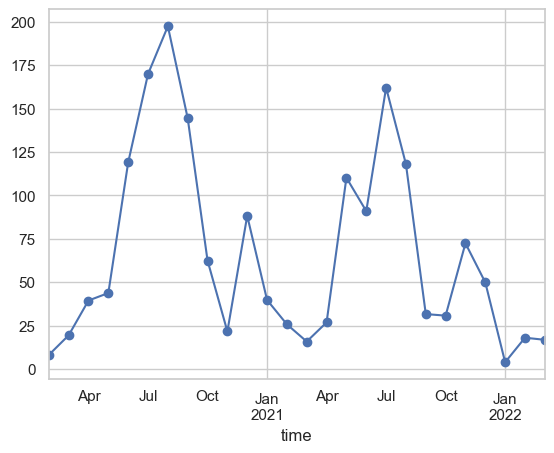

In [33]:
df_RSX = df['RSX'].resample('M').sum()
df_RSX['2020-2':'2022-3'].plot(marker='o')

Daten speichern

In [34]:
df_dymola = df.loc["2020-12"]

<Axes: xlabel='time'>

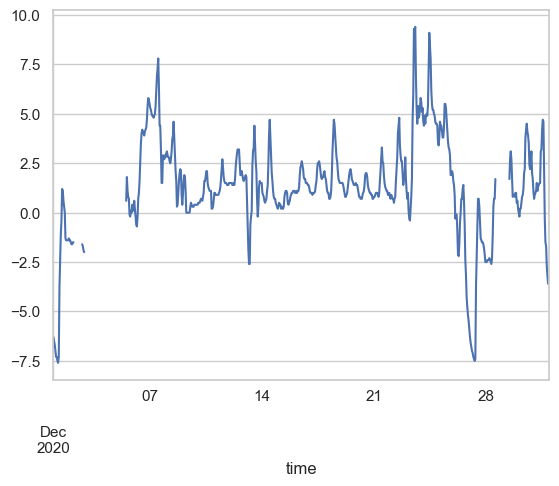

In [35]:
df_dymola.LT2.plot()

<Axes: xlabel='time'>

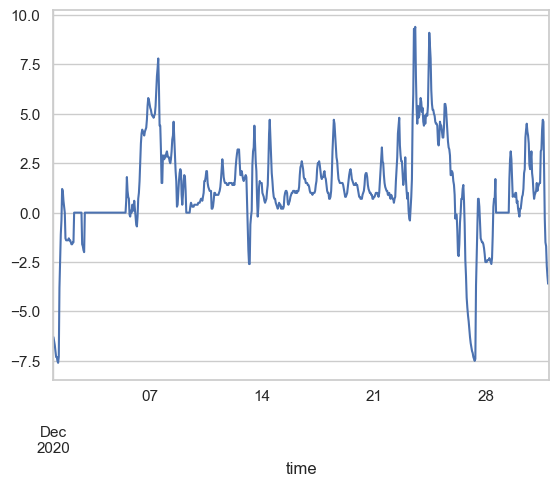

In [36]:
df_dymola["LT2"].fillna(0).plot()

<Axes: xlabel='time'>

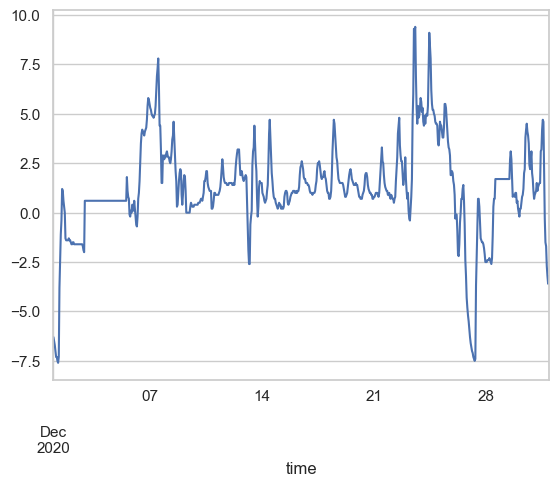

In [37]:
df_dymola["LT2"].bfill().plot()

<Axes: xlabel='time'>

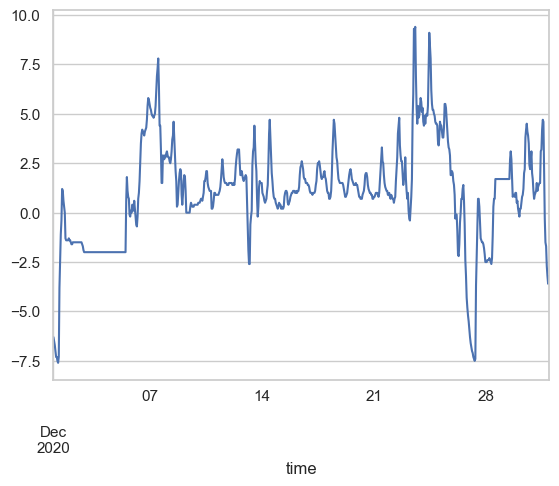

In [38]:
df_dymola["LT2"].ffill().plot()

<Axes: xlabel='time'>

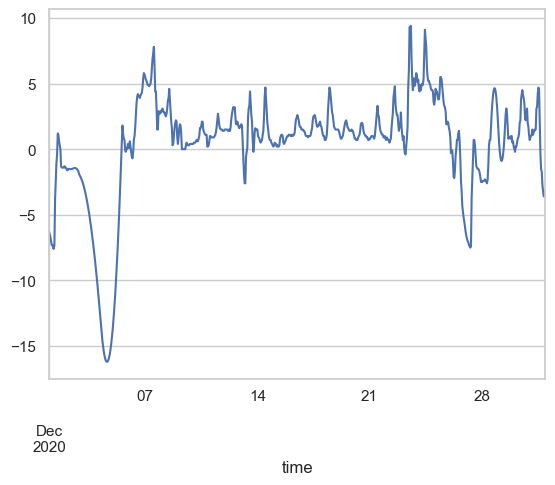

In [39]:
df_dymola["LT2"].interpolate(method="polynomial", order=2).plot()

In [40]:
df_dymola = df_dymola.interpolate(method="polynomial", order=2)

In [41]:
df.to_csv("ZAMG_GRAZ_Datensatz_20000101_20221207.txt")

Datenformat UNIX Zeitstempel: Anzahl der seit dem 1. Januar 1970, 00:00:00 UTC, verstrichenen Sekunden 

In [42]:
df_dymola = df_dymola.assign(unix_timestamp = df_dymola.index)
df_dymola.unix_timestamp = df_dymola.unix_timestamp.apply(lambda x: x.timestamp())
df_dymola = df_dymola.set_index("unix_timestamp")

In [43]:
df_dymola.to_csv("ZAMG_GRAZ_Datensatz_20000101_20221207.txt", sep=" ")

In [44]:
f = open("ZAMG_GRAZ_Datensatz_20000101_20221207.txt","r+")
lines = f.readlines() # lese File
f.seek(0) # zurück zum Anfang
f.write("#1\n") # Schreibe neue Zeile
f.write("double ZAMGdata"+str(df_dymola.shape)+" #") # Schreibe neue Zeile
for line in lines: # Schreibe ursprünglichen Inhalt
    f.write(line)
f.close()

Datenanalyse - Linearer Fit

In [45]:
y=np.array(df['TTX'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(df['TTX'].dropna()).index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept

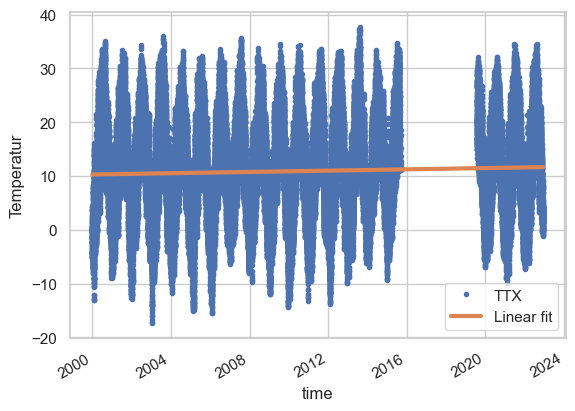

In [46]:
f, ax = plt.subplots(1, 1)
df['TTX'].dropna().plot(ax=ax,marker='.', ls='')
ax.plot(xf1, yf,label='Linear fit', lw=3)
plt.ylabel('Temperatur')
ax.legend();

Wie viel ist die mittlere Lufttemperatur in 2m Höhe vor der Uni Graz seit 2000 gestiegen?

In [47]:
yf[-1]-yf[0]

np.float64(1.3699468235018166)

Regressionsanalyse und Ausreißer

In [48]:
anscombe = sns.load_dataset("anscombe")

In [ ]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'III'"), ci=None)

In [ ]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'III'"), ci=None, robust=True)

#### Endenergieverbrauch in Österreich in TJ 1970-2021

Quelle: Statistik Austria (https://www.statistik.at/)


In [ ]:
energie = pd.read_excel("Energieendverbrauch.xlsx",skiprows=9,skipfooter=8,index_col=1)
energie.drop('Zeit', axis=1, inplace=True)
energie.drop('Bilanzaggregat', axis=0, inplace=True)
energie = energie.loc[energie.index.notnull()]
energie.drop('Energetischer Endverbrauch (EE)', axis=0, inplace=True)
energie = energie.transpose().sort_index().astype(float)
energie.index.name = 'Zeit [Jahre]'
energie.index = energie.index.astype(float)

In [ ]:
energie.head()

In [ ]:
energie.describe().transpose()

In [ ]:
energie.plot(figsize=(10,6),ylabel='Endenergieverbrauch [TJ]', title='Endenergieverbrauch Österreich 1970-2021', xlabel='Zeit [Jahre]').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

Boxplot

In [ ]:
boxplot = sns.boxplot(data=energie, orient='h')
boxplot.set_xlabel("Endenergieverbrauch [TJ]")